In [17]:
import tensorflow as tf
import collections
import numpy as np
import pandas as pd
import random
import math
from sklearn.manifold import TSNE
from matplotlib import pylab

In [40]:
def create_dataset(trainFileName, TestFileName):
    train_data = pd.read_csv(trainFileName,delimiter=";")
    test_data  = pd.read_csv(testFileName,delimiter=";")
    sentences_train = [sentence[:len(sentence) -1 ] for sentence in train_data.translation]
    sentences_test = [sentence[:len(sentence) -1 ] for sentence in train_data.translation]
    sentences = sentences_train + sentences_test
    words = []
    for sentence in sentences:
        sentence = sentence.split()
        for  i in range (len(sentence)):
            word = sentence[i]
            word = str.lower(word)
            word = word.rstrip(",")
            word = word.rstrip(".")
            word = word.rstrip("?")
            words.append(word)
    del train_data
    del sentences
    del sentences_test
    del sentences_train
    return words
    

In [41]:
trainFileName = 'train.sentences.pronunciations.multi.translations.csv'
testFileName = "test.sentences.multi.translations.csv" 
words = create_dataset(trainFileName, testFileName)
vocabulary_size = len(collections.Counter(words).most_common())
print("El vocabulario de este dataset consiste en un total de {} palabras diferentes".format(vocabulary_size))
display(collections.Counter(words).most_common())

El vocabulario de este dataset consiste en un total de 148 palabras diferentes


[('john', 200),
 ('the', 156),
 ('mary', 74),
 ('a', 42),
 ('in', 40),
 ('is', 40),
 ('to', 36),
 ('book', 36),
 ('who', 36),
 ('future', 34),
 ('car', 32),
 ('go', 30),
 ('loves', 28),
 ('there', 26),
 ('that', 26),
 ('buy', 26),
 ('arrives', 26),
 ('will', 24),
 ('visit', 24),
 ("john's", 24),
 ('gives', 24),
 ('likes', 22),
 ('yesterday', 20),
 ('house', 20),
 ('what', 20),
 ('one', 20),
 ('for', 18),
 ('should', 18),
 ('can', 16),
 ("won't", 14),
 ('visits', 14),
 ('new', 14),
 ('woman', 14),
 ('bill', 14),
 ('sure', 12),
 ('vegtables', 12),
 ('he', 12),
 ('i', 10),
 ('corn', 10),
 ('prefers', 10),
 ('has', 10),
 ('buys', 10),
 ('an', 10),
 ('apple', 10),
 ('girl', 10),
 ('box', 10),
 ('blames', 8),
 ('people', 8),
 ('this', 8),
 ('and', 8),
 ('not', 8),
 ('here', 8),
 ('breaks', 8),
 ('down', 8),
 ('sue', 8),
 ('blue', 8),
 ('bought', 8),
 ('really', 8),
 ('give', 8),
 ('teacher', 8),
 ('his', 6),
 ('visited', 6),
 ('eat', 6),
 ('leaves', 6),
 ('tells', 6),
 ('over', 6),
 ("doesn'

In [42]:
def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1 ))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)

In [71]:
data_index = 0
batch_size = 32
# skip_window: int : How many words to consider left and right.
def generate_cbow_batch(batch_size, skip_window):
  global data_index
#   assert batch_size % num_skips == 0
#   assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size, skip_window*2), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size,1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
#   buffer = []
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  
  for i in range(batch_size):
    batch[i] = list(buffer)[:skip_window] + list(buffer)[skip_window+1:]
    labels[i] = buffer[skip_window]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    
  return batch, labels
batch,labels = generate_cbow_batch(10,1)

In [45]:
for i in range (0 , 10 ):
    print ('input: ({0},{1}) -- label:({2}) -- sentence: {0} {2} {1}'.format(reverse_dictionary[batch[i,0]],
                                                                               reverse_dictionary[batch[i,1]],
                                                                               reverse_dictionary[labels[i][0]]))

input: (john,his) -- label:(writes) -- sentence: john writes his
input: (writes,homework) -- label:(his) -- sentence: writes his homework
input: (his,i) -- label:(homework) -- sentence: his homework i
input: (homework,visited) -- label:(i) -- sentence: homework i visited
input: (i,john) -- label:(visited) -- sentence: i visited john
input: (visited,there) -- label:(john) -- sentence: visited john there
input: (john,yesterday) -- label:(there) -- sentence: john there yesterday
input: (there,i) -- label:(yesterday) -- sentence: there yesterday i
input: (yesterday,visited) -- label:(i) -- sentence: yesterday i visited
input: (i,john) -- label:(visited) -- sentence: i visited john


In [72]:
# CBOW model
embedding_size = 32 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 30 # Random set of words to evaluate similarity on.
valid_window = 30 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 30 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  # note the different input dimensions for the CBOW model
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size,skip_window*2])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  # note the sum over the context embeddings for the CBOW model
  #Búsqueda de los parámetros dados en el training batch
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  #Realiza una suma a través de las filas
  embed = tf.reduce_sum(embed, 1)

  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [73]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_cbow_batch(
      batch_size, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()
  

Initialized
Average loss at step 0: 4.537932
Nearest to who: broccoli, breaks, was, party, last, boys, leaves, she,
Nearest to in: chocolate, leaves, borrows, leg, it, UNK, fish, broccoli,
Nearest to house: blames, box, many, next, likes, loves, here, prefer,
Nearest to that: borrows, frank, bought, he, in, candy, new, lived,
Nearest to one: breaks, there, hit, ann, bill, party, someones, finish,
Nearest to to: the, yesterday, car, student, really, apple, tells, girl,
Nearest to car: student, find, to, movie, teacher, reading, old, friend,
Nearest to the: to, throws, owner, being, should, find, frank, and,
Nearest to mary: buys, frank, new, not, fish, puts, someone, will,
Nearest to a: on, future, will, last, wants, finish, puts, potatoes,
Nearest to UNK: what, homework, people, visits, an, boy, leg, it,
Nearest to is: sure, john's, aside, box, corn, really, visits, likes,
Nearest to for: john's, girl, knows, week, says, but, jana, visits,
Nearest to there: finish, owner, apple, told, 

Average loss at step 32000: 0.168043
Average loss at step 34000: 0.167128
Average loss at step 36000: 0.161619
Average loss at step 38000: 0.163921
Average loss at step 40000: 0.163710
Nearest to who: whom, homework, him, she, brother, mary, mother, john,
Nearest to in: give, aside, john, he, john's, of, woman, car,
Nearest to house: party, movie, chicago, writes, there, box, loves, corn,
Nearest to that: blames, what, whom, to, broccoli, coat, can, eats,
Nearest to one: boy, UNK, owner, vegtables, for, videotape, ann, bill,
Nearest to to: should, is, frank's, can, aside, has, really, says,
Nearest to car: coat, there, movie, woman, party, boy, leaves, future,
Nearest to the: china, chicago, some, told, which, many, blue, a,
Nearest to mary: stolen, frank, leg, who, this, party, eats, and,
Nearest to a: old, down, some, was, not, finish, the, mother,
Nearest to UNK: vegtables, one, for, homework, brother, boys, go, be,
Nearest to is: aside, loves, many, visit, likes, yesterday, to, tel

Average loss at step 72000: 0.157583
Average loss at step 74000: 0.158340
Average loss at step 76000: 0.153153
Average loss at step 78000: 0.153434
Average loss at step 80000: 0.153203
Nearest to who: whom, him, homework, brother, she, mary, mother, eats,
Nearest to in: give, john's, he, aside, john, of, car, ann,
Nearest to house: party, movie, chicago, writes, there, box, loves, sure,
Nearest to that: to, what, whom, blames, broccoli, eats, writes, can,
Nearest to one: boy, UNK, for, owner, vegtables, ann, videotape, john,
Nearest to to: should, is, can, frank's, whom, aside, that, has,
Nearest to car: coat, there, movie, party, boy, leaves, woman, york,
Nearest to the: china, some, chicago, down, told, many, here, a,
Nearest to mary: stolen, frank, leg, who, this, fred, eats, was,
Nearest to a: down, old, some, was, not, the, mother, visit,
Nearest to UNK: vegtables, one, for, homework, brother, boys, go, last,
Nearest to is: loves, aside, many, visit, yesterday, to, likes, tells,
N

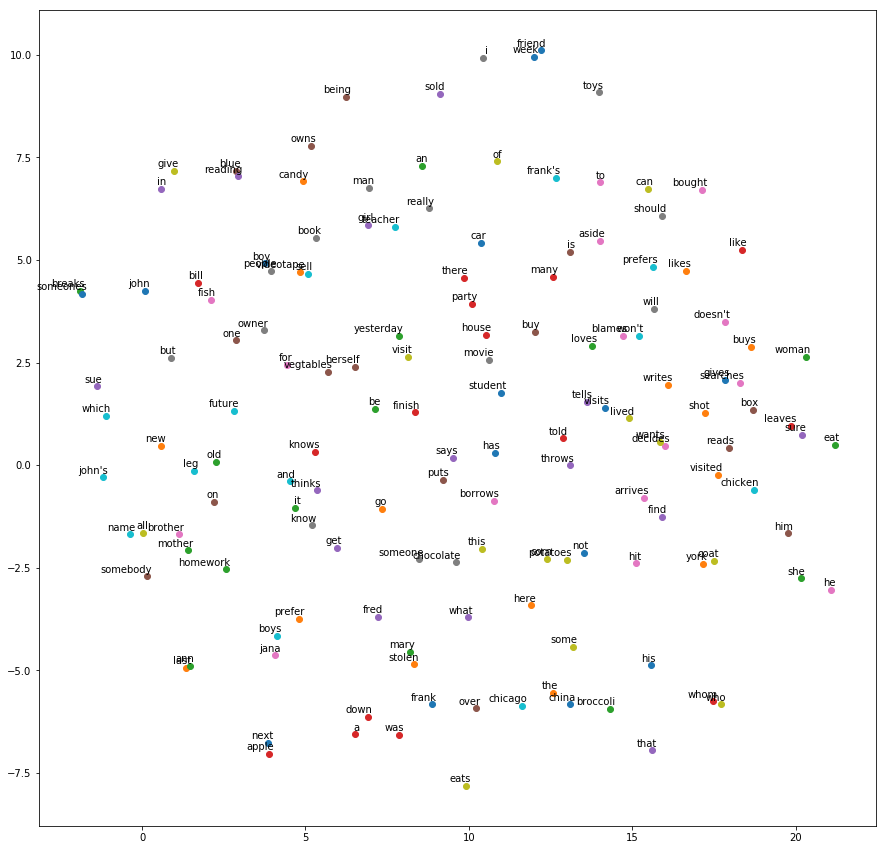

In [74]:
num_points = vocabulary_size-1

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)